# Defining Problem Statement & Exploratory Data Analysis

# Problem Statement:

Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

# Concepts Tested:

• Recommender Engine

• Collaborative Filtering (Item-based & User-based Approach)

• Pearson Correlation

• Nearest Neighbors using Cosine Similarity

• Matrix Factorization

# Importing Libraries

In [3]:
!pip install pandas numpy matplotlib seaborn scikit-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from sklearn.neighbors import NearestNeighbors

import warnings #supress warnings
warnings.filterwarnings('ignore')

C:\Users\junai\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Importing Data and removing non-relevant columns

In [3]:
raw_movies = pd.read_fwf('zee-movies.dat', encoding='ISO-8859-1')
raw_ratings = pd.read_fwf('zee-ratings.dat', encoding='ISO-8859-1')
raw_users = pd.read_fwf('zee-users.dat', encoding='ISO-8859-1')

In [4]:
print(f'Shape of Movies data : {raw_movies.shape}')
print(f'Shape of Ratings data : {raw_ratings.shape}')
print(f'Shape of Users data : {raw_users.shape}')

Shape of Movies data : (3883, 3)
Shape of Ratings data : (1000209, 1)
Shape of Users data : (6040, 1)


In [5]:
print('-'*80)
print(raw_movies.sample(100).head(3))
print('-'*80)
print(raw_ratings.sample(100).head(3))
print('-'*80)
print(raw_users.sample(100).head(3))

--------------------------------------------------------------------------------
                              Movie ID::Title::Genres Unnamed: 1 Unnamed: 2
610                614::Loaded (1994)::Drama|Thriller        NaN        NaN
430   434::Cliffhanger (1993)::Action|Adventure|Crime        NaN        NaN
1378                1399::Marvin's Room (1996)::Drama        NaN        NaN
--------------------------------------------------------------------------------
       UserID::MovieID::Rating::Timestamp
445857           2750::1405::4::973200712
68030             456::1197::5::976299858
271712           1643::2421::2::995610935
--------------------------------------------------------------------------------
     UserID::Gender::Age::Occupation::Zip-code
3449                     3450::M::25::5::78251
5268                     5269::M::18::0::37211
3818                    3819::M::25::12::36115


In [6]:
#Creating Clean Dataframe for Movies Data
movies=pd.DataFrame(raw_movies['Movie ID::Title::Genres'].copy(deep=True))
movies['movieID']=movies['Movie ID::Title::Genres'].apply(lambda x: x.split('::')[0]).astype('int')
movies['title']=movies['Movie ID::Title::Genres'].apply(lambda x: x.split('::')[1])
movies['genres']=movies['Movie ID::Title::Genres'].apply(lambda x: x.split('::')[-1])
movies.drop(columns=['Movie ID::Title::Genres'],inplace=True)
movies.drop_duplicates(keep='last',inplace=True)

In [7]:
import re
def get_year(name):
    if len(re.findall(r'\s\((\d{4})\)$', name)) == 1 : 
        return re.findall(r'\s\((\d{4})\)$', name)[0]
    else: return '0'

movies['release_year'] = movies['title'].apply(get_year).astype('int')

In [8]:
#Dropping rows where abnormal data is observed
movies=movies.loc[movies['release_year'] != 0]
movies=movies.loc[movies['title'] != movies['genres']]

In [9]:
#Replacing incomplete words in Genre Columns
movies['genres'].replace({ 'Acti$' : 'Action', 
                          'Adv$' : 'Adventure', 'Advent$' : 'Adventure', 'Adventu$' : 'Adventure', 'Adventur$' : 'Adventure', 
                          'Animati$' : 'Animation', 'Chi$' : 'Children', 'Chil$' : 'Children', 'Childr$' : 'Children', 
                          'Childre$' : 'Children', 'Com$' : 'Comedy', 'Come$' : 'Comedy', 'Comed$' : 'Comedy', 
                          'Docu$' : 'Documentary', 'Documen$' : 'Documentary', 'Document$' : 'Documentary', 
                          'Documenta$' : 'Documentary', 'Dr$' : 'Drama', 'Dram$' : 'Drama', 'Fant$' : 'Fantasy', 
                          'Fantas$' : 'Fantasy', 'Horr$' : 'Horror', 'Horro$' : 'Horror', 'Music$' : 'Musical', 
                          'Ro$' : 'Romance', 'Rom$' : 'Romance', 'Roma$' : 'Romance', 'Roman$' : 'Romance', 'Sci$' : 'Sci-Fi', 
                          'Sci-$' : 'Sci-Fi', 'Sci-F$' : 'Sci-Fi', 'Thri$' : 'Thriller', 'Thrille$' : 'Thriller', 'Wa$' : 'War',
                          'We$' : 'Western', 'Wester$' : 'Western'}, regex=True, inplace = True)
movies['genres'].replace({"Children's" : "Children", "Children'": "Children", "Sci-Fi" : "SciFi", 
                          "Film-Noir": "FilmNoir" }, regex=True, inplace = True) 
movies['genres'] = movies['genres'].str.lower()

In [10]:
print('-'*80)
print(f'Shape of Movies data : {movies.shape}')
print('-'*80)
movies.sample(100).head()

--------------------------------------------------------------------------------
Shape of Movies data : (3857, 4)
--------------------------------------------------------------------------------


,movieID,title,genres,release_year
2661,2730,Barry Lyndon (1975),drama,1975
2442,2511,"Long Goodbye, The (1973)",crime,1973
3483,3552,Caddyshack (1980),comedy,1980
1117,1133,Talking About Sex (1994),comedy|drama,1994
3730,3799,Pokémon the Movie 2000 (2000),animation|children,2000


In [11]:
#Creating Clean Dataframe for Ratings Data
ratings=pd.DataFrame(raw_ratings['UserID::MovieID::Rating::Timestamp'].copy(deep=True))
ratings['userID']=ratings['UserID::MovieID::Rating::Timestamp'].apply(lambda x: x.split('::')[0]).astype('int')
ratings['movieID'] = ratings['UserID::MovieID::Rating::Timestamp'].apply(lambda x: x.split('::')[1]).astype('int')
ratings['rating'] = ratings['UserID::MovieID::Rating::Timestamp'].apply(lambda x: x.split('::')[2]).astype('int')
ratings['timestamp'] = ratings['UserID::MovieID::Rating::Timestamp'].apply(lambda x: x.split('::')[-1])
ratings.drop(columns = ['UserID::MovieID::Rating::Timestamp'], inplace = True)
ratings.drop_duplicates(keep='last', inplace = True)

In [12]:
ratings['timestamp']=pd.to_datetime(ratings['timestamp'],unit='s')

In [13]:
print('-'*80)
print(f'Shape of Ratings Data : {ratings.shape}')
print('-'*80)
ratings.sample(100).head()

--------------------------------------------------------------------------------
Shape of Ratings Data : (1000209, 4)
--------------------------------------------------------------------------------


,userID,movieID,rating,timestamp
81723,543,2174,5,2000-12-06 16:33:51
236921,1440,480,4,2000-11-20 22:46:43
529877,3272,2701,4,2000-10-11 08:00:32
57631,390,2902,3,2000-12-08 21:36:02
161950,1033,2451,3,2000-11-23 16:24:23


In [14]:
#creating Clean DataFrame for Users Data
users = pd.DataFrame(raw_users['UserID::Gender::Age::Occupation::Zip-code'].copy(deep = True))
users['userID'] = users['UserID::Gender::Age::Occupation::Zip-code'].apply(lambda x: x.split('::')[0]).astype('int')
users['gender'] = users['UserID::Gender::Age::Occupation::Zip-code'].apply(lambda x: x.split('::')[1])
users['age'] = users['UserID::Gender::Age::Occupation::Zip-code'].apply(lambda x: x.split('::')[2]).astype('int')
users['occupation'] = users['UserID::Gender::Age::Occupation::Zip-code'].apply(lambda x: x.split('::')[3]).astype('int')
users['zip_code'] = users['UserID::Gender::Age::Occupation::Zip-code'].apply(lambda x: x.split('::')[-1])
users.drop(columns = ['UserID::Gender::Age::Occupation::Zip-code'], inplace = True)
users.drop_duplicates(keep='last', inplace = True)

In [15]:
#Convert Gender column to 0:female and 1:male
users['gender']=users['gender'].map({'F':0,'M':1}).astype('int')

In [16]:
print('-'*80)
print(f'Shape of Users data : {users.shape}')
print('-'*80)
users.sample(100).head()

--------------------------------------------------------------------------------
Shape of Users data : (6040, 5)
--------------------------------------------------------------------------------


,userID,gender,age,occupation,zip_code
1836,1837,1,25,2,08817
3038,3039,0,50,3,33611
5607,5608,1,18,3,78722
5496,5497,1,25,4,60201
4186,4187,0,56,20,63026


In [17]:
# Creating CSV for analysis
movies.to_csv('movies.csv')
ratings.to_csv('ratings.csv')
users.to_csv('users.csv')

# Exploratory Data Analysis

Movie count by release year

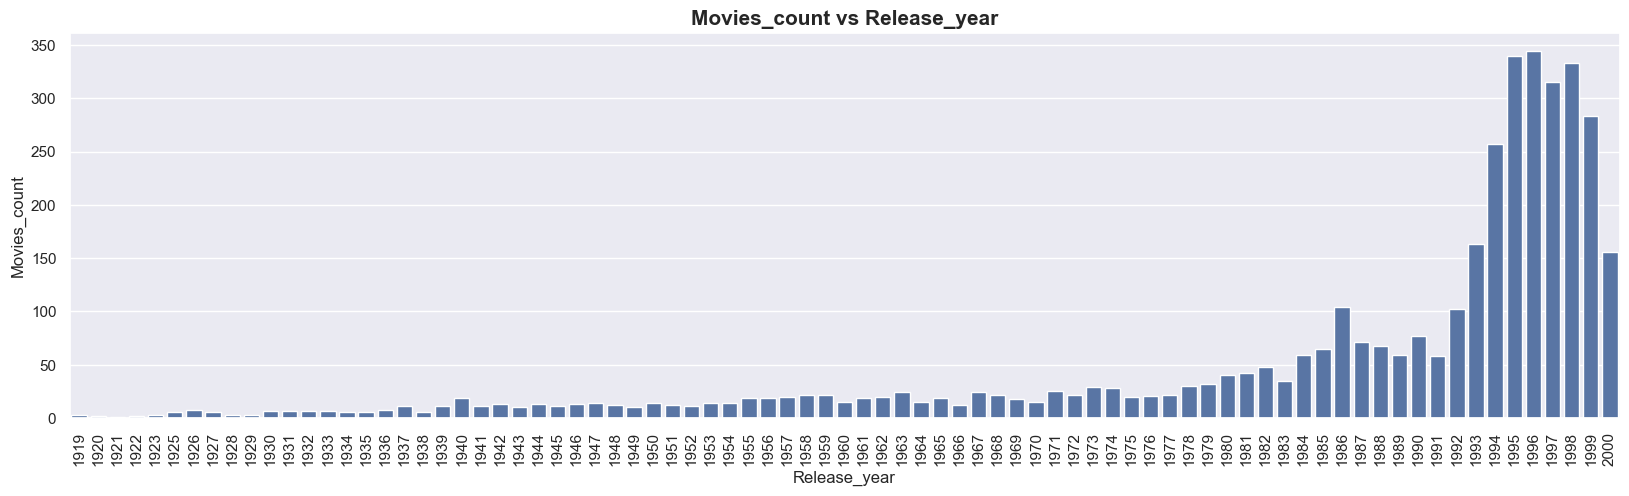

In [20]:
plt.figure(figsize=(20,5))
x=movies['release_year'].value_counts().index
y=movies['release_year'].value_counts().values
sns.barplot(x=x,y=y)
plt.xticks(rotation=90)
plt.xlabel('Release_year')
plt.ylabel('Movies_count')
plt.title('Movies_count vs Release_year',fontsize=15,fontweight='bold')
plt.show()

Movie Count by Genre

In [22]:
movie_genre=movies[['title','genres']].copy(deep=True)
movie_genre=movie_genre.assign(genres=movie_genre['genres'].str.split('|')).explode('genres')
movie_genre.genres=movie_genre.genres.str.strip()

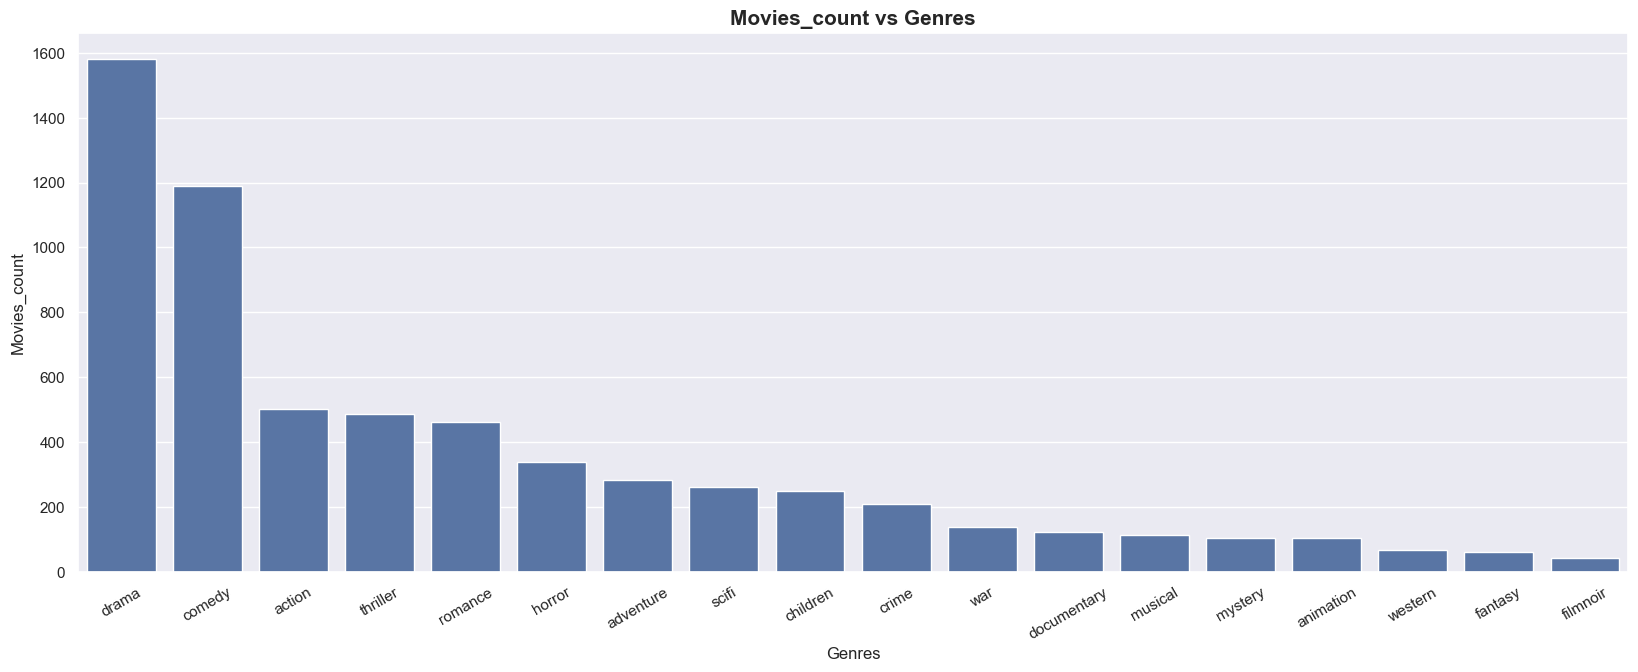

In [23]:
plt.figure(figsize=(20,7))
x = movie_genre.genres.value_counts().index
y = movie_genre.genres.value_counts().values
sns.barplot(x=x[:18], y=y[:18])
plt.xticks(rotation=30)
plt.xlabel('Genres')
plt.ylabel('Movies_count')
plt.title('Movies_count vs Genres', fontsize = 15, fontweight = 'bold')
plt.show()

Users Gender, Age and Occupation distribution

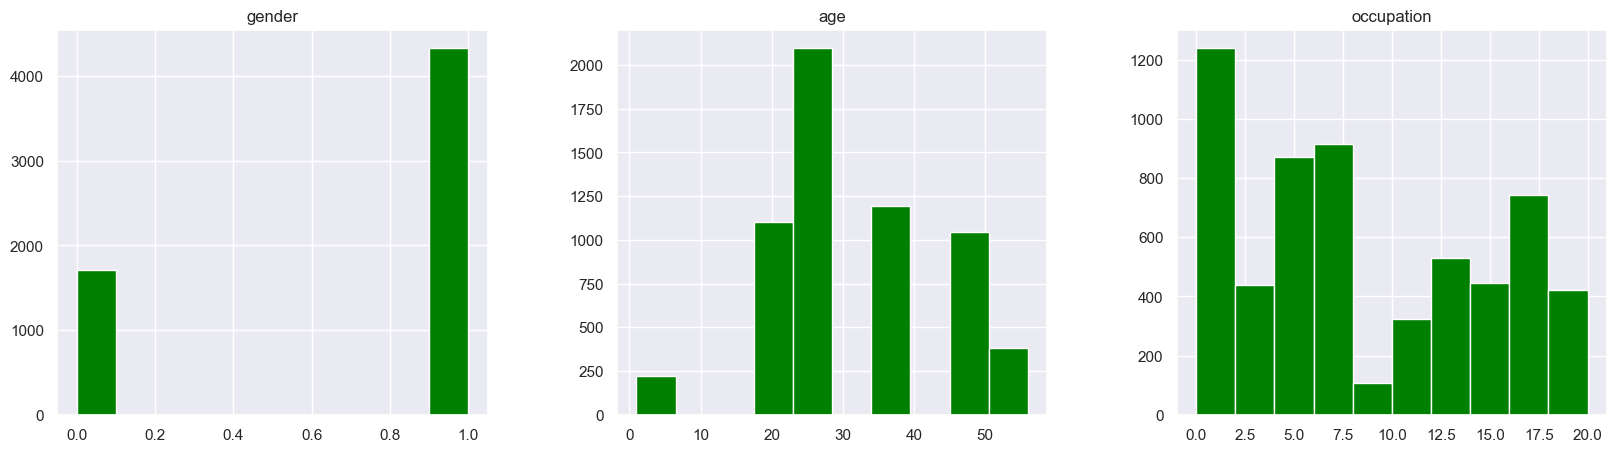

In [25]:
users[['gender','age','occupation']].hist(figsize=(20,5),layout=(1,3),color='green')
plt.show()

Merging the data files and creating a single consolidated dataframe

In [27]:
#Merging all 3 dataframes to single Dataframe : data
data=ratings.merge(movies,how='inner',on='movieID')
data=data.merge(users,how='inner',on='userID')

In [28]:
data.to_csv('data.csv')

In [29]:
print('-'*80)
print(f'Shape of Combined data : {data.shape}')
print('-'*80)
data.sample(100).head()

--------------------------------------------------------------------------------
Shape of Combined data : (996144, 11)
--------------------------------------------------------------------------------


,userID,movieID,rating,timestamp,title,genres,release_year,gender,age,occupation,zip_code
432172,2643,3918,2,2000-11-07 03:06:41,Hellbound: Hellraiser II (1988),horror,1988,1,45,17,99005
444554,2752,3203,3,2000-11-02 20:16:41,Dead Calm (1989),thriller,1989,1,25,15,77006
769481,4605,1735,1,2000-07-21 18:37:15,Great Expectations (1998),drama|romance,1998,1,25,15,92656
577840,3540,1221,5,2000-08-21 18:20:24,"Godfather: Part II, The (1974)",action|crime|drama,1974,1,18,17,57106
215679,1314,1005,1,2000-11-29 21:54:58,D3: The Mighty Ducks (1996),children|comedy,1996,0,18,4,68154


In [30]:
data.describe(include=np.number).round(2).T

,count,mean,std,min,25%,50%,75%,max
userID,996144.0,3024.00,1728.27,1.0,1505.0,3069.0,4476.0,6040.0
movieID,996144.0,1867.03,1096.03,1.0,1032.0,1836.0,2770.0,3952.0
rating,996144.0,3.58,1.12,1.0,3.0,4.0,4.0,5.0
release_year,996144.0,1986.76,14.31,1919.0,1982.0,1992.0,1997.0,2000.0
gender,996144.0,0.75,0.43,0.0,1.0,1.0,1.0,1.0
age,996144.0,29.73,11.75,1.0,25.0,25.0,35.0,56.0
occupation,996144.0,8.03,6.53,0.0,2.0,7.0,14.0,20.0


In [31]:
data.describe(include='object').round(2).T

,count,unique,top,freq
title,996144,3682,American Beauty (1999),3428
genres,996144,308,comedy,116779
zip_code,996144,3439,94110,3782


# Create Movie Recommender Using Various Models

Group the data according to the average rating and no. of ratings

In [34]:
data_pivot_rating=pd.pivot_table(data,index='title',values='rating',aggfunc=['count','mean']).round(5)
data_pivot_rating.columns=['_'.join(col).strip() for col in data_pivot_rating.columns.values]
data_pivot_rating.sort_values(by=['count_rating','mean_rating'],ascending=False,inplace=True)

In [35]:
data_pivot_rating.head(10)

,count_rating,mean_rating
title,,
American Beauty (1999),3428,4.31739
Star Wars: Episode IV - A New Hope (1977),2991,4.45369
Star Wars: Episode V - The Empire Strikes Back (1980),2990,4.29298
Star Wars: Episode VI - Return of the Jedi (1983),2883,4.02289
Jurassic Park (1993),2672,3.76385
Saving Private Ryan (1998),2653,4.33735
Terminator 2: Judgment Day (1991),2649,4.05851
"Matrix, The (1999)",2590,4.31583
Back to the Future (1985),2583,3.99032


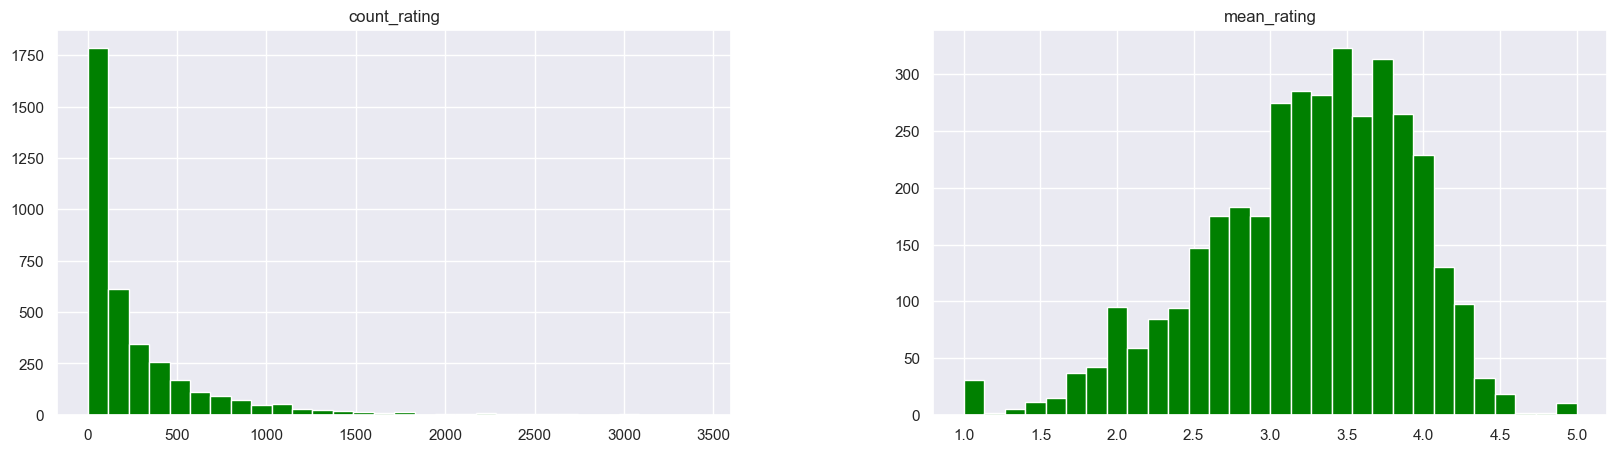

In [36]:
data_pivot_rating.hist(figsize=(20,5),bins=30,layout=(1,2),color='green')
plt.show()

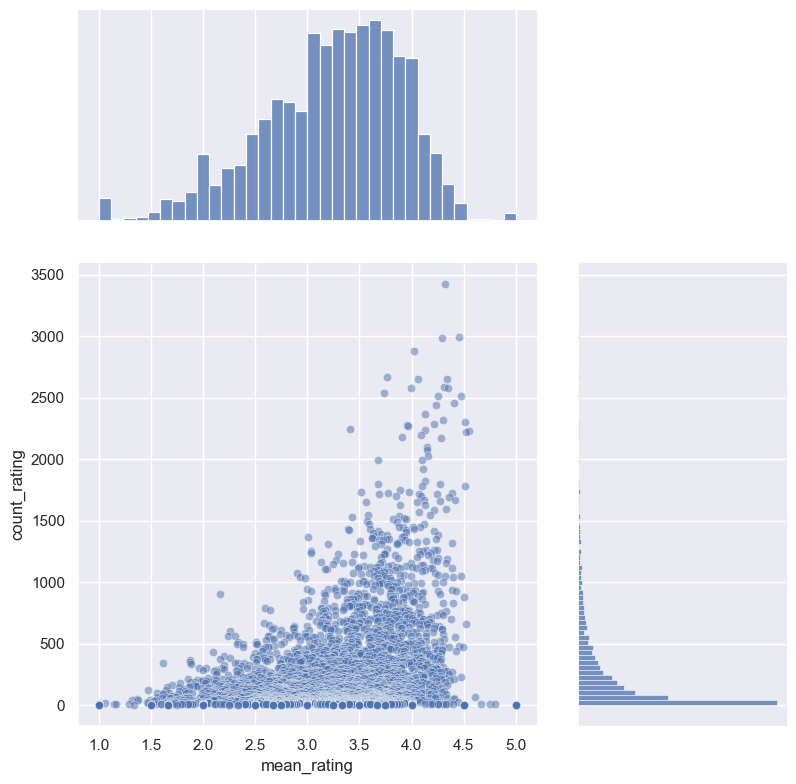

In [37]:
sns.jointplot(x='mean_rating',y='count_rating',data=data_pivot_rating,alpha=0.5,height=8,ratio=2)
plt.show()

Creating a pivot table of movie titles & user ID and imputing NaN values

In [39]:
movie_matrix=pd.pivot_table(data,index='userID',columns='title',values='rating',fill_value=0)

In [40]:
print('-'*80)
print(f'Shape of Movie Matrix : {movie_matrix.shape}')
print('-'*80)
movie_matrix.sample(100).head()

--------------------------------------------------------------------------------
Shape of Movie Matrix : (6040, 3682)
--------------------------------------------------------------------------------


title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
userID,,,,,,,,,,,,,,,,,,,,,
4782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1698,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,...,0.0,2.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,4.0
4127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5428,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Movie_Movie Similarity Matrix (Correlation between Movies)

In [42]:
# Creating Similarity Matrix for 20 Top Rated Movies
n=20
sample_movies=data_pivot_rating.head(n).index
movie_matrix_sample=movie_matrix.loc[:,movie_matrix.columns.isin(sample_movies)]

--------------------------------------------------------------------------------
Shape of Movie-Movie Similarity Matrix :(20, 20)
--------------------------------------------------------------------------------


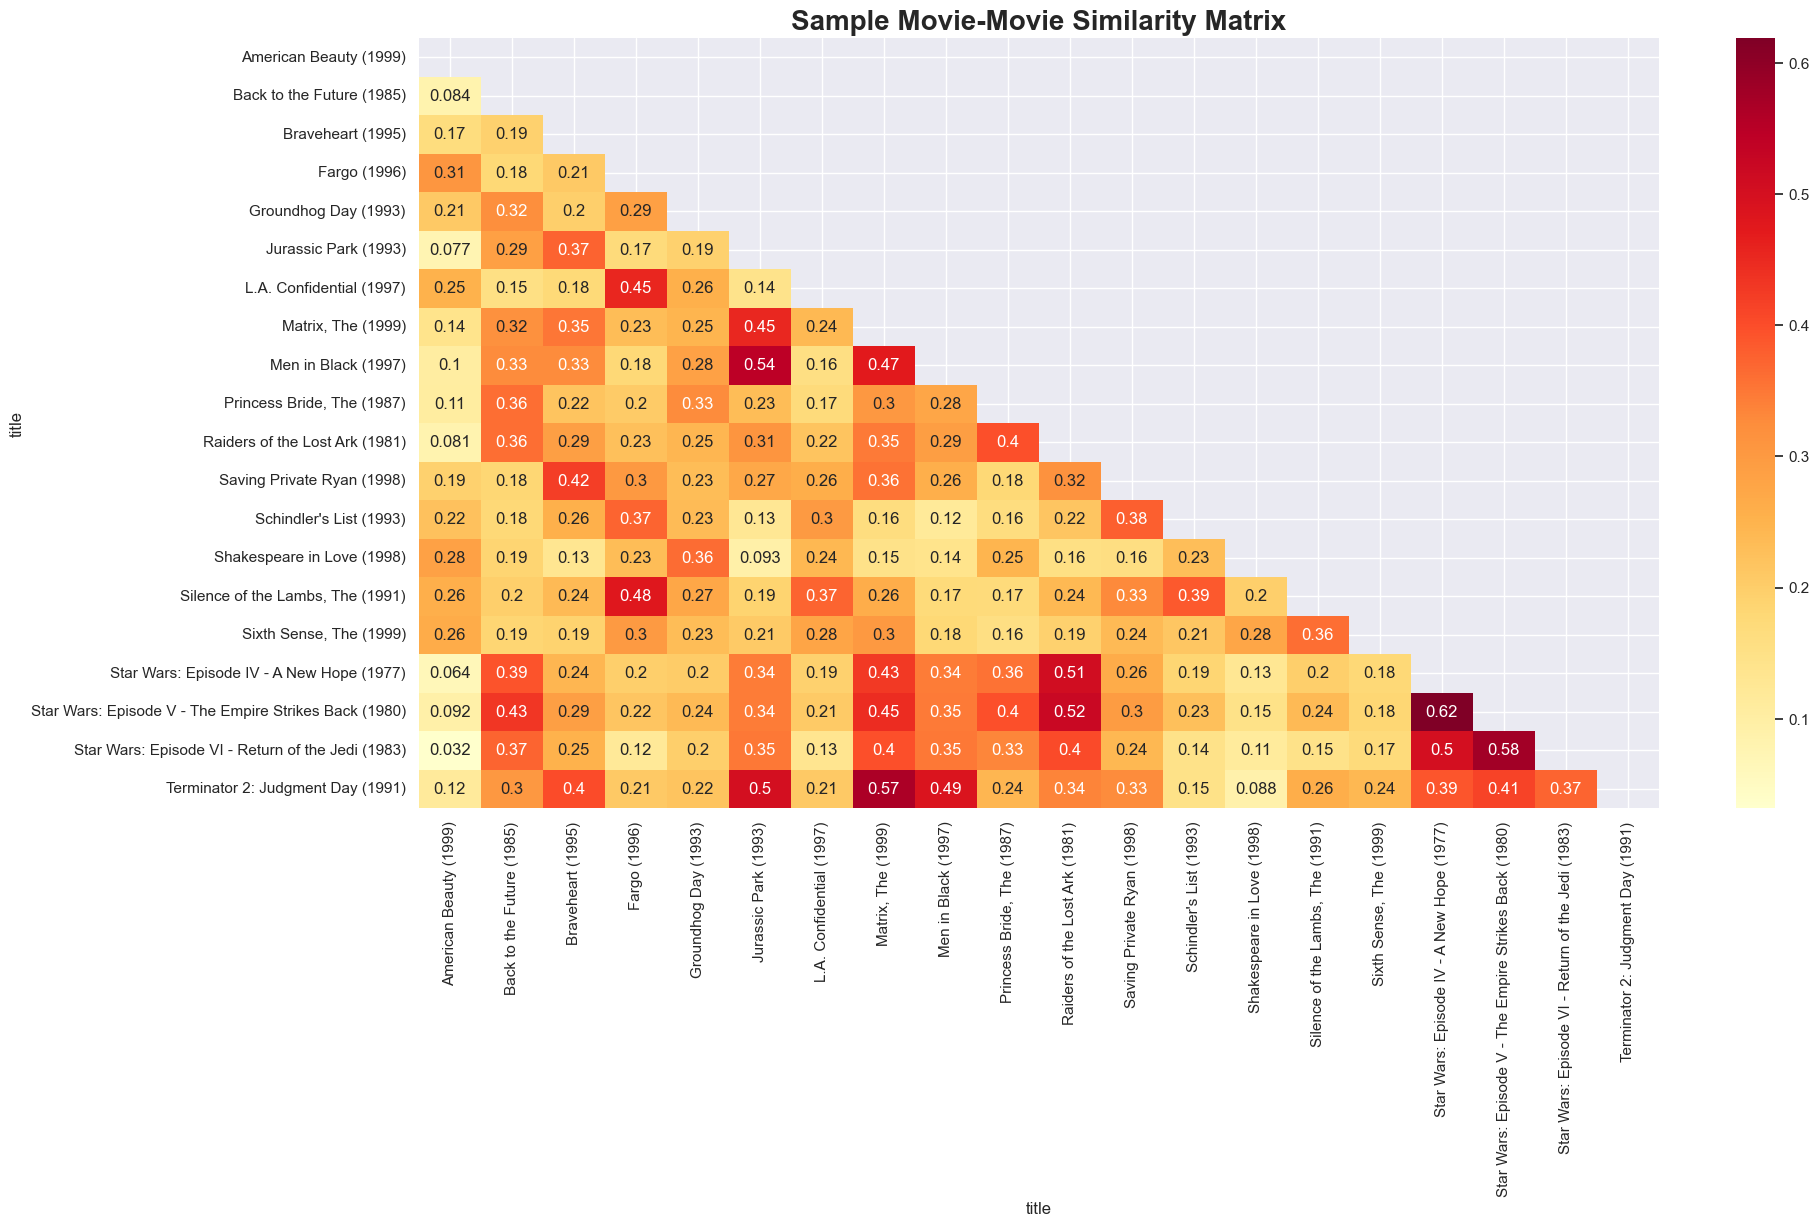

In [43]:
print('-'*80)
print(f'Shape of Movie-Movie Similarity Matrix :{movie_matrix_sample.corr().shape}')
print('-'*80)
plt.figure(figsize=(20,10))
mask=np.triu(movie_matrix_sample.corr())
plt.title('Sample Movie-Movie Similarity Matrix',fontsize=20,fontweight='bold')
sns.heatmap(movie_matrix_sample.corr(),annot=True,cmap='YlOrRd',mask=mask)
plt.show()

User-User Similarity Matrix (Correlation between users)

In [45]:
# Creating Similarity Matrix random 20 users
m=20
sample_users=users.userID.sample(m)
sample_users=sample_users.values
user_matrix_sample=movie_matrix.loc[movie_matrix.index.isin(sample_users)]
user_matrix_sample=user_matrix_sample.T

--------------------------------------------------------------------------------
Shape of User-user similarity Matrix :(20, 20)
--------------------------------------------------------------------------------


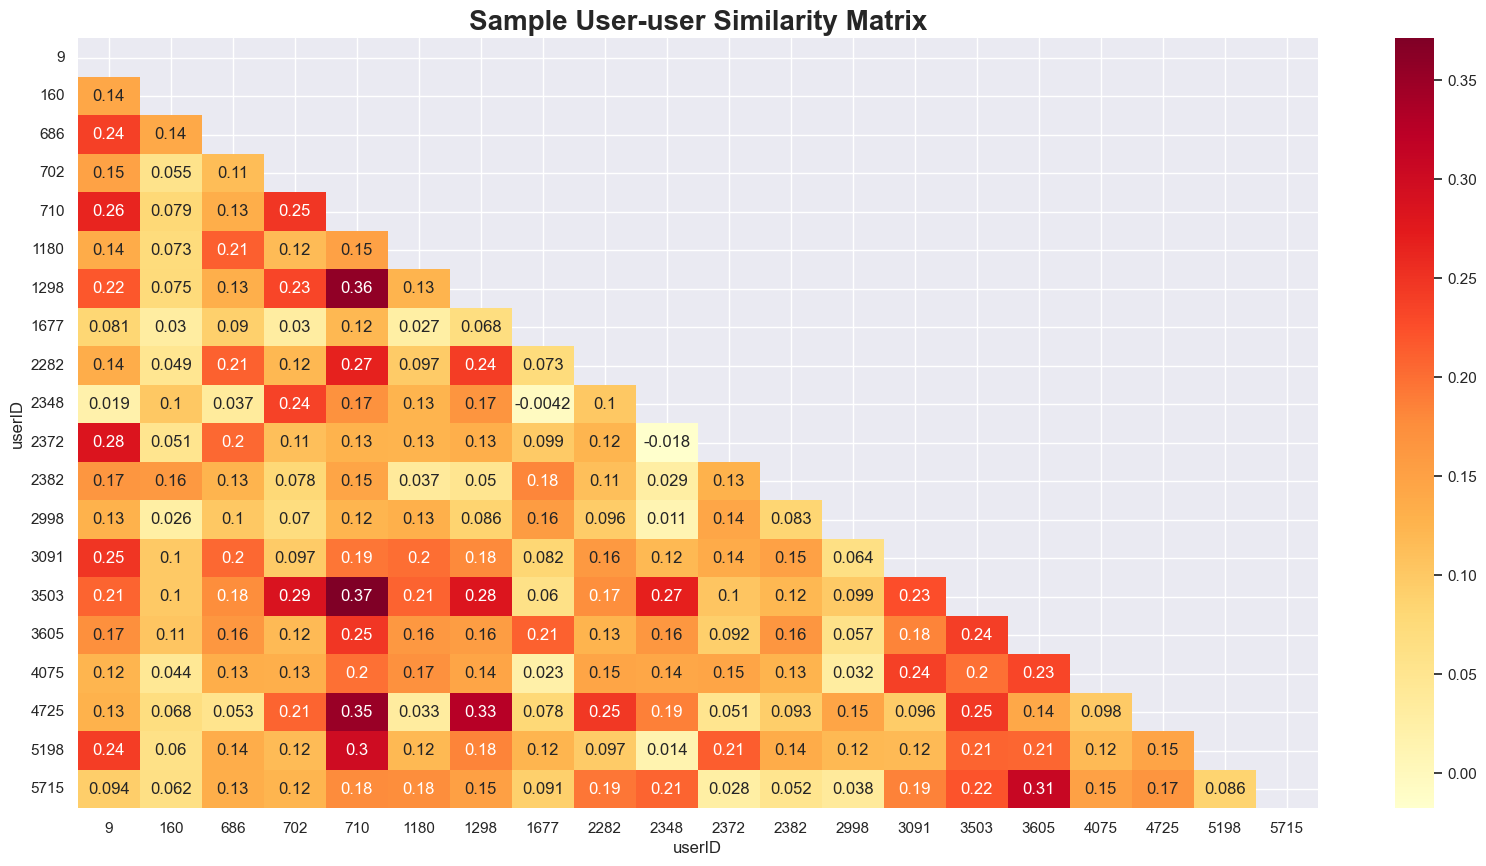

In [46]:
print('-'*80)
print(f'Shape of User-user similarity Matrix :{user_matrix_sample.corr().shape}')
print('-'*80)
plt.figure(figsize=(20,10))
plt.title('Sample User-user Similarity Matrix', fontsize=20,fontweight='bold')
mask=np.triu(user_matrix_sample.corr())
sns.heatmap(user_matrix_sample.corr(),annot=True,mask=mask,cmap='YlOrRd')
plt.yticks(rotation=0)
plt.show()

# Model 1: Recommender System based on Pearson Correlation

In [48]:
# Creating function for Movie Recommender System

def recommender_1(movie,movie_matrix,data_pivot_rating,n_recommend=5):
    movie_rating = movie_matrix[movie]
    similar_movies = movie_matrix.corrwith(movie_rating)
    corr_movie= pd.DataFrame(similar_movies,columns=['Correlation'])
    corr_movie.dropna(inplace=True)
    corr_movie = corr_movie.join(data_pivot_rating['count_rating'])
    recommended_movies = corr_movie[corr_movie['count_rating']>100].sort_values('Correlation',ascending=False).head(n_recommend+1)
    print('-'*100)
    print(f'Top {n_recommend} Recommended Movies to "{movie}" are as follow:')
    print('-'*100)
    for mov in recommended_movies.index:
        if mov != movie:print(mov)
    print('-'*100)
    return None

In [49]:
# Testing for 1 Movie
movie = 'Shawshank Redemption, The (1994)'
recommender_1(movie,movie_matrix,data_pivot_rating,n_recommend=10)

----------------------------------------------------------------------------------------------------
Top 10 Recommended Movies to "Shawshank Redemption, The (1994)" are as follow:
----------------------------------------------------------------------------------------------------
Silence of the Lambs, The (1991)
Good Will Hunting (1997)
Pulp Fiction (1994)
Schindler's List (1993)
Fargo (1996)
GoodFellas (1990)
Usual Suspects, The (1995)
Sling Blade (1996)
Jerry Maguire (1996)
Few Good Men, A (1992)
----------------------------------------------------------------------------------------------------


In [50]:
# Results for top 5 most rated Moviees in dataset
test_movies=data_pivot_rating.head(5).index
for mov in test_movies:
    recommender_1(mov,movie_matrix,data_pivot_rating,n_recommend=5)

----------------------------------------------------------------------------------------------------
Top 5 Recommended Movies to "American Beauty (1999)" are as follow:
----------------------------------------------------------------------------------------------------
Being John Malkovich (1999)
Election (1999)
Pulp Fiction (1994)
Fight Club (1999)
Clerks (1994)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Top 5 Recommended Movies to "Star Wars: Episode IV - A New Hope (1977)" are as follow:
----------------------------------------------------------------------------------------------------
Star Wars: Episode V - The Empire Strikes Back (1980)
Raiders of the Lost Ark (1981)
Star Wars: Episode VI - Return of the Jedi (1983)
Terminator, The (1984)
Alien (1979)
-------------------------------------------------------------------------

# Model 2 : Recommender System based on Cosine Similarity, KNearestNeighbours

In [52]:
def recommender_2(movie,movie_matrix,n_recommend=5):
    nn_recommender=NearestNeighbors(metric='cosine')
    nn_recommender.fit(movie_matrix.T)
    distance,neighbors= nn_recommender.kneighbors([movie_matrix.loc[:,movie]],n_neighbors=n_recommend+1)
    recommended_movies=[movie_matrix.T.iloc[i].name for i in neighbors[0]]
    print('-'*100)
    print(f'Top {n_recommend} Recommended Movies to "{movie}" are as follow:')
    print('-' *100)
    for mov in recommended_movies:
        if mov != movie :print(mov)
    print('-'*100)
    return None

In [53]:
# Testing for 1 Movie
movie= 'Shawshank Redemption, The (1994)'
recommender_2(movie,movie_matrix,n_recommend=10)

----------------------------------------------------------------------------------------------------
Top 10 Recommended Movies to "Shawshank Redemption, The (1994)" are as follow:
----------------------------------------------------------------------------------------------------
Silence of the Lambs, The (1991)
Pulp Fiction (1994)
Fargo (1996)
Schindler's List (1993)
Good Will Hunting (1997)
Saving Private Ryan (1998)
GoodFellas (1990)
American Beauty (1999)
Usual Suspects, The (1995)
Groundhog Day (1993)
----------------------------------------------------------------------------------------------------


In [54]:
# Results for top 5 most rated Movies in dataset
test_movies= data_pivot_rating.head(5).index
for mov in test_movies:
    recommender_2(mov,movie_matrix,n_recommend=5)

----------------------------------------------------------------------------------------------------
Top 5 Recommended Movies to "American Beauty (1999)" are as follow:
----------------------------------------------------------------------------------------------------
Being John Malkovich (1999)
Fargo (1996)
Pulp Fiction (1994)
Silence of the Lambs, The (1991)
Shakespeare in Love (1998)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Top 5 Recommended Movies to "Star Wars: Episode IV - A New Hope (1977)" are as follow:
----------------------------------------------------------------------------------------------------
Star Wars: Episode V - The Empire Strikes Back (1980)
Star Wars: Episode VI - Return of the Jedi (1983)
Raiders of the Lost Ark (1981)
Terminator, The (1984)
Alien (1979)
------------------------------------------------

# Model 3 : Recommender System based on Matrix Factorization ( Using Surprise Package)

In [56]:
!pip install surprise

from surprise import Reader, Dataset, SVD 
from surprise.model_selection import cross_validate

Evaluate the model in terms of the Root Mean Squared Error and Mean Absolute Percentage Error

In [58]:
d=4 
reader = Reader(rating_scale = (1,5))
svd = SVD(random_state=23,n_factors=d,n_epochs=10,verbose=True)

data_svd=Dataset.load_from_df(data[['userID','movieID','rating']],reader)
results= cross_validate(svd,data_svd,measures=['RMSE','MAE'],cv=3,verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9098  0.9115  0.9094  0.9103  0.0009  
MAE (testset)     0.7209  0.7219  0.7206  0.7211  0.0006  
Fit time          2.07    2.28    2.21    2.19    0.09    
Test time         2.15    2.26    1.98    2.13    0.11    


# Model Performance 3 Folds CV:

- Mean RMSE = 0.9100
- Mean MAE = 0.7209

Average Time taken to Fit Model : 7.25 and to Test model = 3.10

In [60]:
from recommenders.datasets.python_splitters import python_random_split
print("Recommenders library is working correctly!")

Recommenders library is working correctly!


In [61]:
!pip install --user recommenders
# splitting our data into train set and testset 
from recommenders.datasets.python_splitters import python_random_split
train, test = python_random_split(data[['userID', 'movieID', 'rating']], 0.75)

In [62]:
print(train.shape)
print(test.shape)

(747108, 3)
(249036, 3)


In [108]:
test.head(3)

,userID,movieID,rating
575967,3532,1701,2
872991,5293,608,4
466994,2888,2424,1


In [110]:
#'reader' is being used to get rating scale(for data, the scale is [1,5])
reader=Reader(rating_scale=(1,5))

#Surprise needs to build an internal model of the data. We here use the load_from_df method to build a dataset object
train_set=Dataset.load_from_df(train,reader=reader).build_full_trainset()
train_set

In [112]:
# Fitting the Model using SVD Algo

from recommenders.utils.timer import Timer
svd1=SVD(random_state=23,n_factors=4,n_epochs=10,verbose=True)

with Timer() as train_time:
    svd1.fit(train_set)

print('Took {} seconds for training,'.format(train_time.interval))

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Took 2.6790239999972982 seconds for training,


In [114]:
# Create predictions after fitting the model

from recommenders.models.surprise.surprise_utils import predict
predictions=predict(svd1,test,usercol='userID',itemcol='movieID')
predictions.head()

,userID,movieID,prediction
0,3532,1701,3.721704
1,5293,608,4.080484
2,2888,2424,3.419244
3,1489,2550,2.444016
4,5493,1399,3.047185


In [116]:
#Merging predictions with Actual Ratings and plotting to visualize the results
check_predictions = test.merge(predictions, how='left',left_on=['userID','movieID'],right_on=['userID','movieID'])

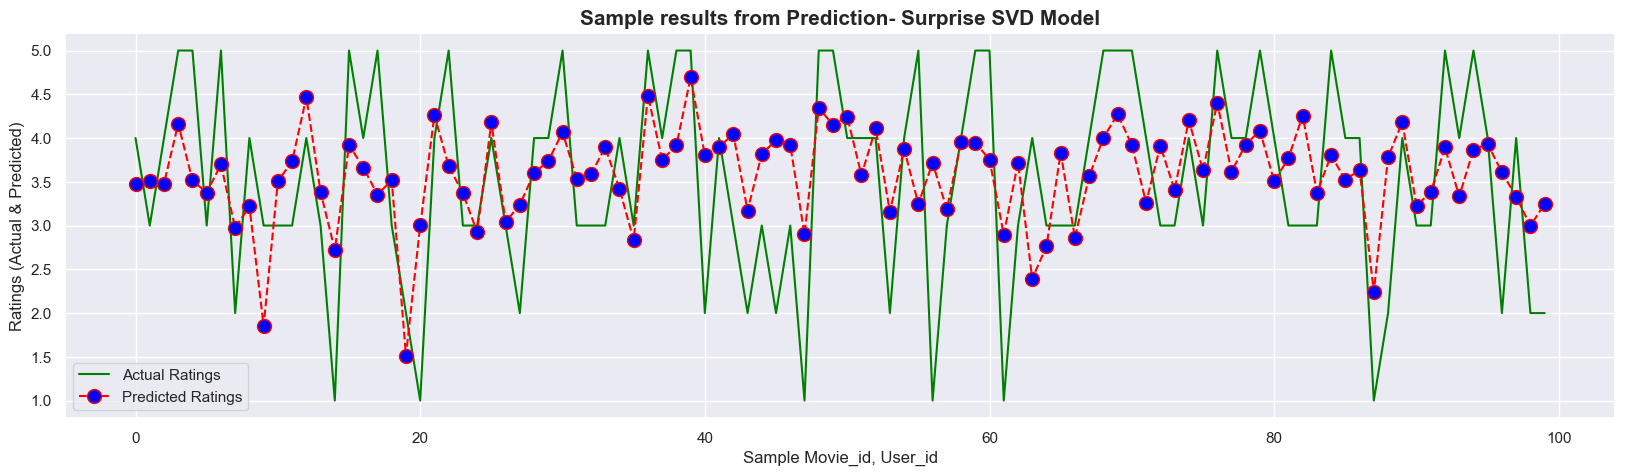

In [118]:
plt.figure(figsize=(20,5))
d=100
x=range(d)
initial_pointer=np.random.randint(100)
final_pointer=initial_pointer+d

y1=check_predictions.loc[range(initial_pointer,final_pointer),'rating']
y2=check_predictions.loc[range(initial_pointer,final_pointer),'prediction']

plt.plot(x,y1,label='Actual Ratings',color='green')
plt.plot(x,y2,label='Predicted Ratings',color='red',linestyle='dashed',marker='o',markerfacecolor='blue',markersize=10)

plt.ylabel('Ratings (Actual & Predicted)')
plt.xlabel('Sample Movie_id, User_id')
plt.title('Sample results from Prediction- Surprise SVD Model',fontsize=15,fontweight='bold')
plt.legend()
plt.show()

# Questionnaire

1. Users of which age group have watched and rated most number of movies ?

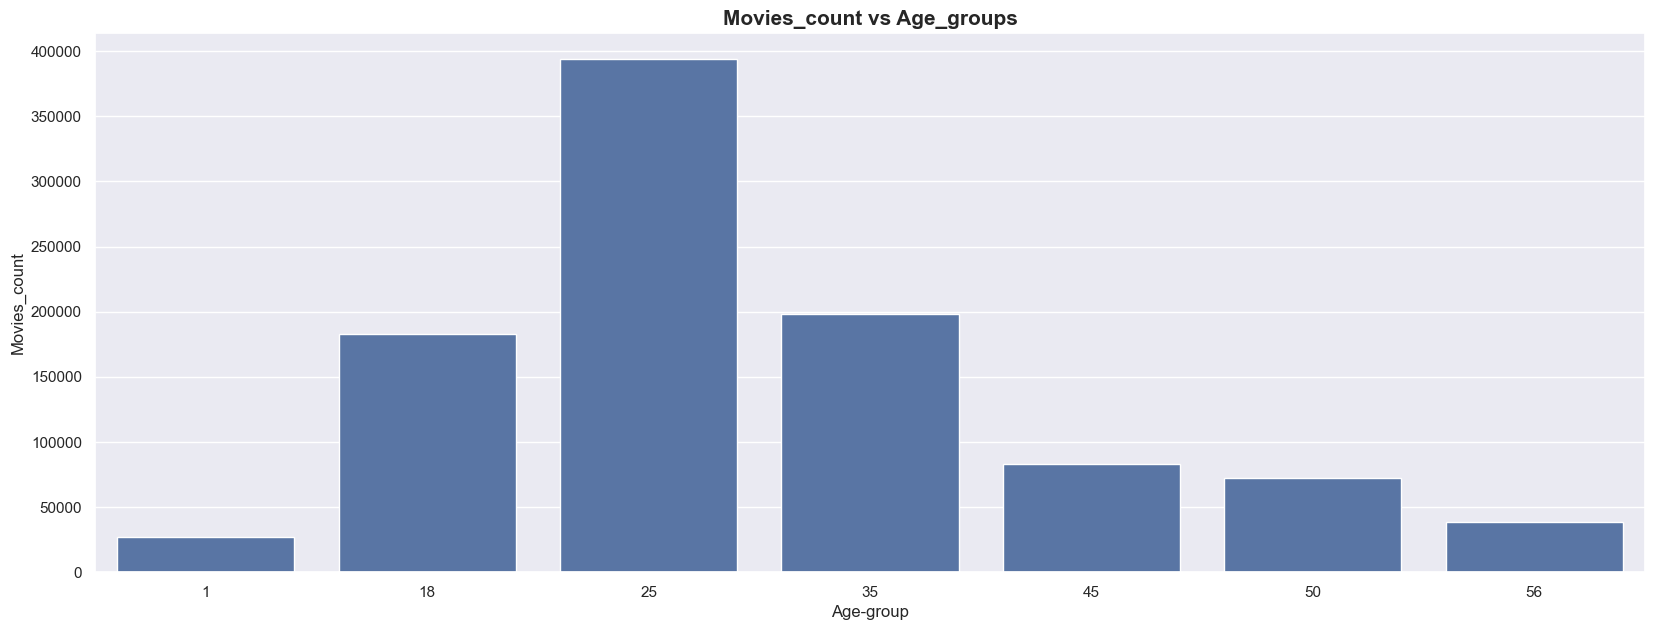

In [122]:
plt.figure(figsize=(20,7))
x=data.age.value_counts().sort_index().index
y=data.age.value_counts().sort_index().values
sns.barplot(x=x,y=y)
plt.xlabel('Age-group')
plt.ylabel('Movies_count')
plt.title('Movies_count vs Age_groups',fontsize=15,fontweight='bold')
plt.show()

 Users of age group 25: "25-34" have watched and rated most number of movies followed by 35: "35-44" and 18: "18-24

2. Users belonging to which profession have watched and rated the most movies ?

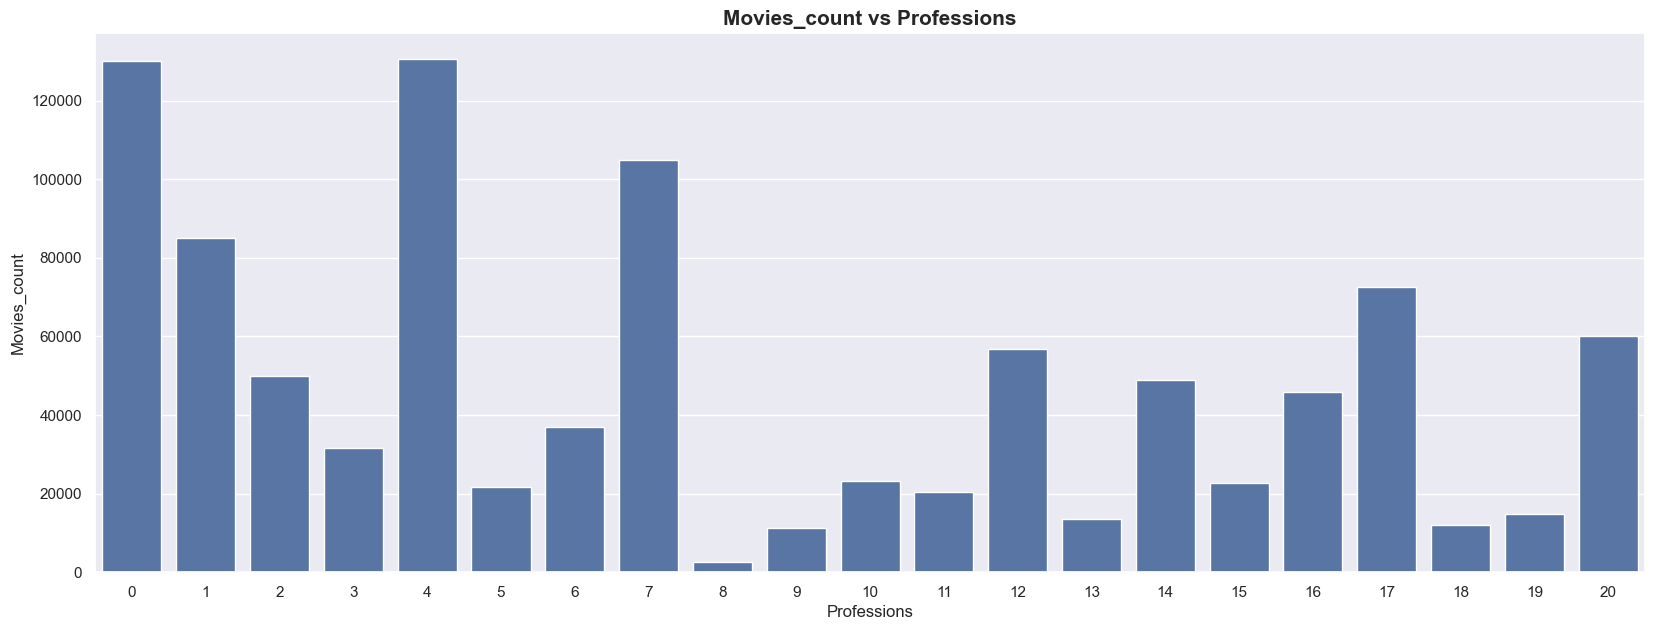

In [128]:
plt.figure(figsize=(20,7))
x= data.occupation.value_counts().sort_index().index
y=data.occupation.value_counts().sort_index().values
sns.barplot(x=x,y=y)
plt.xlabel('Professions')
plt.ylabel('Movies_count')
plt.title('Movies_count vs Professions', fontsize = 15, fontweight = 'bold')
plt.show()

Users of profession 

4: "college/grad student" have watched and rated most number of movies followed by

0: "other" or not specified,

7: "executive/managerial" and

1: "academic/educator".

3. Most of the users in our dataset who’ve rated the movies are Male. (T/F)

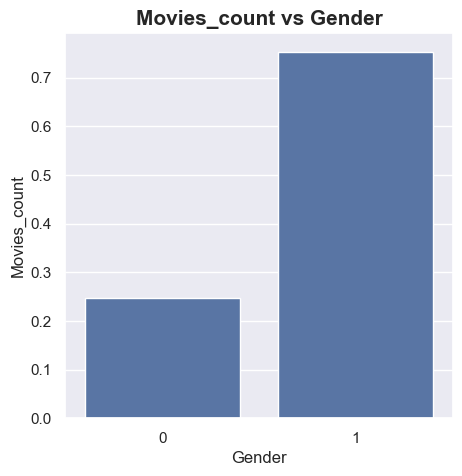

In [133]:
plt.figure(figsize=(5,5))
x=data.gender.value_counts(normalize=True).sort_index().index
y=data.gender.value_counts(normalize=True).sort_index().values
sns.barplot(x=x,y=y)
plt.xlabel('Gender')
plt.ylabel('Movies_count')
plt.title('Movies_count vs Gender', fontsize = 15, fontweight = 'bold')
plt.show()

Out of all responses, 75% were given by "1: Male". Hence the statement is True.

Around 25% responses were received from "0: Female"

4. Most of the movies present in our dataset were released in which decade?

a. 70s

b. 90s

c. 50s

d.80s

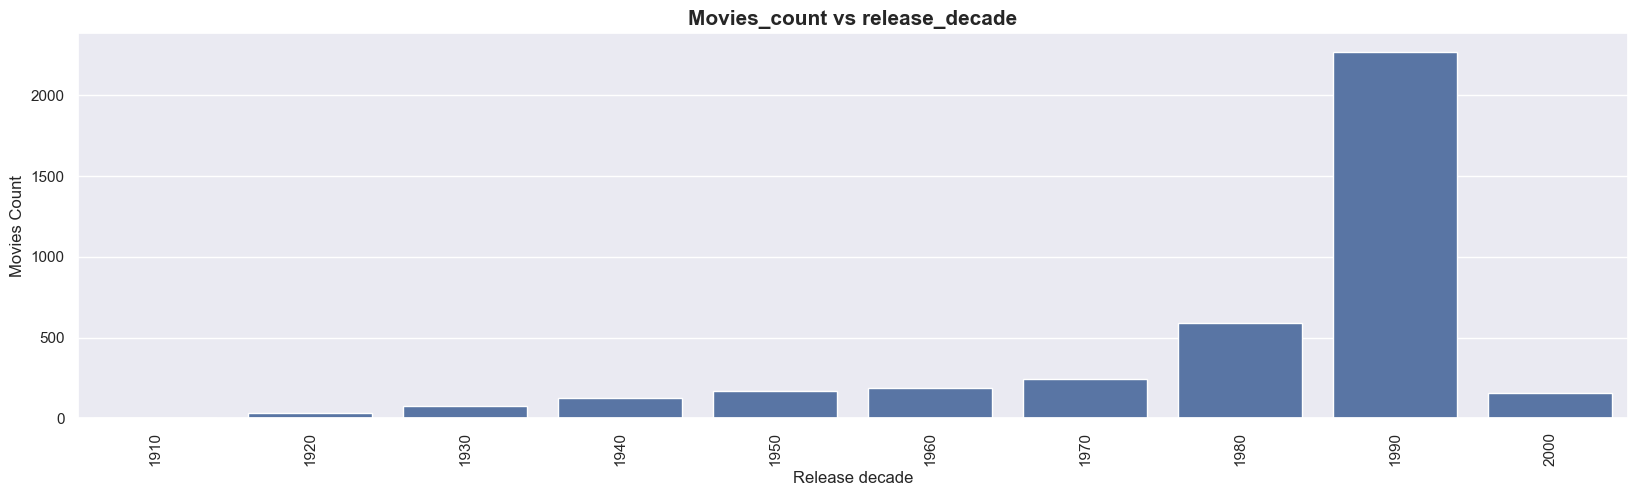

In [140]:
x=movies.groupby((movies.release_year//10)*10)['movieID'].count().index
y=movies.groupby((movies.release_year//10)*10)['movieID'].count().values

plt.figure(figsize=(20,5))
sns.barplot(x=x,y=y)
plt.xticks(rotation=90)
plt.xlabel('Release decade')
plt.ylabel('Movies Count')
plt.title('Movies_count vs release_decade',fontsize=15,fontweight='bold')
plt.show()

=> Most of the movies present in our dataset were released in Decade 90s (1990)

5. The movie with maximum no. of ratings is

In [144]:
data_pivot_rating.head(5)

,count_rating,mean_rating
title,,
American Beauty (1999),3428,4.31739
Star Wars: Episode IV - A New Hope (1977),2991,4.45369
Star Wars: Episode V - The Empire Strikes Back (1980),2990,4.29298
Star Wars: Episode VI - Return of the Jedi (1983),2883,4.02289
Jurassic Park (1993),2672,3.76385


American Beauty is the movie with the highest no of ratings

6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach

In [148]:
movie='Liar Liar (1997)'
recommender_1(movie,movie_matrix,data_pivot_rating,n_recommend=3)
recommender_2(movie,movie_matrix,n_recommend=3)

----------------------------------------------------------------------------------------------------
Top 3 Recommended Movies to "Liar Liar (1997)" are as follow:
----------------------------------------------------------------------------------------------------
Mrs. Doubtfire (1993)
Dumb & Dumber (1994)
Ace Ventura: Pet Detective (1994)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Top 3 Recommended Movies to "Liar Liar (1997)" are as follow:
----------------------------------------------------------------------------------------------------
Mrs. Doubtfire (1993)
Ace Ventura: Pet Detective (1994)
Dumb & Dumber (1994)
----------------------------------------------------------------------------------------------------


7. On the basis of approach, Collaborative Filtering methods can be classified into ___-based and ___-based.

=> User-based (which measures the similarity between target users and other users)
&
Item-based (which measures the similarity between the items that target users rate or interact with and other items)

8. Pearson Correlation ranges between ____ & ____ whereas, Cosine Similarity belongs to the interval between ___ and ___ .

=> Pearson Correlation ranges between -1 to 1 whereas, Cosine Similarity belongs to the interval between 0 and 1.

9. Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.

=> Model Performance 3 Folds CV: Mean RMSE = 0.9100 and Mean MAE = 0.7209

10. Give the sparse ‘row’ matrix representation for the following dense matrix -

[ [1 0]

[3 7] ]

=> Array representation:

rows = [0, 1, 1 ]

columns = [0, 0, 1 ]

values = [1, 3, 7 ]

Linked List representation:

[row, column, value, pointer_to_next_node]

[0, 0, 1 ] ---> [1, 0,, 3 ] ---> [1, 1, 7 ] (null)